In [1]:
## Finding soln to coupled eq.s
from scipy.integrate import solve_ivp,odeint, solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.special import hyp2f1

In [10]:
# Define Ea^2 = H/H0 a^2 to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# Approx for small scale, horizon crossing
def phi_funct_highk(a,k,cosmo):
    return 3*(np.sin(a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1]))) - (a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1])))*\
                   np.cos(a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1]))))/(a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1])))**3\
        + cosmo[-1]*0.141833*3*np.sqrt(3)/((cosmo[-1]+cosmo[-2])*(k**3 *a**3))
    
def phi_funct_lowk(a,k,cosmo):
    y = a*(cosmo[0]+cosmo[1])/(cosmo[-1]+cosmo[-2])
    kappa = cosmo[-1]/(2*(cosmo[-2]+cosmo[-1]))
    return -(3-4*kappa)*((y/(y+1))**(4*kappa) * y**(3-4*kappa)*((12*kappa+1)*np.sqrt(1+y) * hyp2f1(0.5-4*kappa,3-4*kappa,4-4*kappa,-y) +(4*kappa-3)*(y+1)**(4*kappa))/\
           ((4*kappa-3)*(8*kappa-1)*np.sqrt(y+1)))*np.sqrt(1+y)/(y**3 * 2)

def functInt(z,A,B):
    return np.exp(B*z)*z**(2-4*A)*(1+z)**(4*A -B-3/2)*(3*z+4)

def phi_funct_firstorderk(a,k,cosmo):
    y = a*(cosmo[0]+cosmo[1])/(cosmo[-1]+cosmo[-2])
    B =(cosmo[-1]+cosmo[-2])*k**2/(30*(cosmo[0]+cosmo[1])**2)*0.001
    
    return 16*B*np.log(y+1) - 18*B*y**4/(7*np.sqrt(y+1)) +312*B*y**3/(35*np.sqrt(y+1)) \
            - (6736*B*y**2 -16864*B*y-33728*B)/(315*np.sqrt(y+1)) +  phi_funct_lowk(a,k,cosmo)
    
def phi_dot(a, k, params, cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    delta, phi, theta_r0, theta_r1, v = params
    Omega_m = Omega_c + Omega_b
    
    return -(Omega_m*delta + 4*Omega_r*theta_r0/a)/(2*Easquared(a, cosmo)**2) \
           - k**2 *phi*a/(3*Easquared(a, cosmo)**2) - phi/a + 2*alpha_C*phi/(k**2 * a*Easquared(a, cosmo)**2)

def theta_r0_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return - k*theta_r1/Easquared(a, cosmo) + phi_dot(a, k, params, cosmo)

def theta_r1_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return k*(theta_r0 + phi)/(3*Easquared(a, cosmo))

def delta_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return 3*phi_dot(a, k, params, cosmo) + k**2 * v/Easquared(a, cosmo)

def v_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return -v/a -phi/Easquared(a, cosmo)

def solution_coupled(a,params, cosmo, k):
    return [delta_dot(a, k, params, cosmo),\
           phi_dot(a, k, params, cosmo),\
           theta_r0_dot(a, k, params, cosmo),\
           theta_r1_dot(a, k, params, cosmo),
           v_dot(a, k, params, cosmo)]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1 if k >> aH
# note: k is unitless (ie. k is actually k/H0)
# note: this is for the quasistatic approximation (all temporal derivatives are much smaller than spatial derivatives)
#       but not for superhorizon approximation (we don't enforce k >> aH)

def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_g = Omega_r - alpha_C
    if alpha_C == 0:
        return (k**2)*a**2/((k**2 + 3*(Easquared(a,cosmo1)/a)**2)*a**2)
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_g - Omega_k - alpha_C
        return (k**2)*a**2/((k**2 + 3*(Easquared(a,cosmo1)/a)**2)*a**2 - 6*alpha_C)

# FUNCTIONS FOR Boundary Value Problem (BVP)

# Second order ODE for D_+(a)
def solverGrowth(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)))

# BC for our ODE. D(a=0) = 0, D(a = 1) = 1
# can set value of either function (y[0] or y[1]) at the lower (a) or upper (b) limit
def bc(ya, yb, lowerbound):
    return np.array([ya[0]-lowerbound, yb[0] - 1])

# Function that returns D, f for a given cosmo, a and k
def solve_for_growth(a, cosmo1, k, lowerbound):
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for j in range(len(k)):
        # x range over which to solve fun
        x = np.logspace(np.log10(1e-6),0,100)
        # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
        y_init = np.zeros((2, x.size))
        y_init[0] = x
        integrator = solve_bvp(lambda z, y: solverGrowth(z, y, cosmo1, k[j]), lambda z,y: bc(z,y,lowerbound), x, y_init, max_nodes=90000,tol=1e-8)
        soln = integrator.sol(a)
        #print(np.max(integrator.rms_residuals)) -- to check if we are converging to the right results
        print(integrator.status) #-- to check if we are converging to the right results
        D_val[j] = soln[0]
        a3EDdot = soln[1]
        f_val[j] = a3EDdot/(D_val[j]*Easquared(a,cosmo1))
        # Normalized to one today
        #D_val[j] = D_val[j]/D_val[j][-1]
    return D_val, f_val

# comoving distance between a_min and a_max
def xi(a_min, a_max,cosmo):
    return sc.integrate.quad(lambda x: 1/(Easquared(x,cosmo)), a_min, a_max)[0]


In [11]:
print(3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)
print(1.347887678*3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)
print(3*(1+cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)
print(1.347887678*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)

print((1+cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)

1.2066588442358464
1.6264405876952186
1.6466705778820767
0.5421468625650728
0.5488901926273589


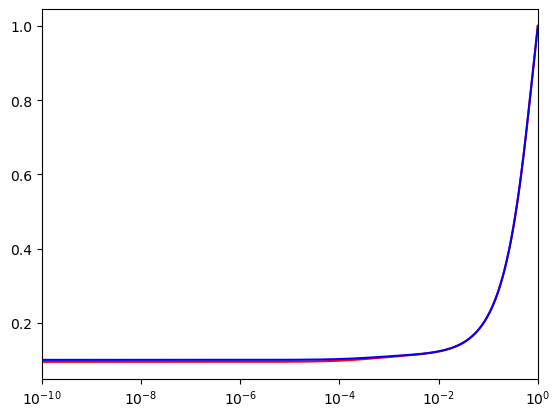

In [13]:
k = 3
a_0 = 1e-15
a_1 = 1e-15
Omg_rad = 9.227e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct = lambda x,y: solution_coupled(x,y, cosmo, k)
soln = solve_ivp(funct,
                 (a_0,1), 
                 np.array([3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,
                            -1,
                            (1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,
                            -k*a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_1, cosmo)),
                            a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_1, cosmo))]),
                 t_eval=np.logspace(np.log10(a_0), 0, 1000), 
                 method ='LSODA', 
                 rtol =1e-4)

plt.plot(soln.t,soln.y[0]/soln.y[0][-1], color="r")


# Showing that quasistatic approximation doesn't work
#soln_approx = solve_for_growth(np.logspace(np.log10(1e-6), 0, 500), cosmo, [k,k], soln.y[0][find_nearest(soln.t, 1e-6)]/soln.y[0][-1])[0][0]
#plt.plot(np.logspace(np.log10(1e-6), 0, 500),soln_approx, color="g")

alpha_C = 1e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]

funct1 = lambda x,y: solution_coupled(x,y, cosmo, k)
#soln1 = solve_ivp(funct1,(a_1,1), np.array([soln.y[0][find_nearest(soln.t,a_1)],soln.y[1][find_nearest(soln.t,a_1)],soln.y[2][find_nearest(soln.t,a_1)],soln.y[3][find_nearest(soln.t,a_1)],soln.y[4][find_nearest(soln.t,a_1)]]),\
#                  t_eval=np.logspace(np.log10(a_1), 0, 1000), method="BDF", atol = 1e-11, rtol=1e-13,max_step=(1 - a_1) / 5000)
#soln1 = solve_ivp(funct1,(a_1,1), np.array([soln.y[0][find_nearest(soln.t,a_1)],phi_funct_lowk(a_1,k,cosmo),soln.y[2][find_nearest(soln.t,a_1)],soln.y[3][find_nearest(soln.t,a_1)],soln.y[4][find_nearest(soln.t,a_1)]]),\
#                  t_eval=np.logspace(np.log10(a_1), 0, 1000), method ='LSODA', rtol =1e-13)

#soln1 = solve_ivp(funct1,(a_1,1), np.array([3/2,1,1/2,-k*a_1/(6*Easquared(a_1, cosmo)), a_1/(2*Easquared(a_1, cosmo))]),\
#                  t_eval=np.logspace(np.log10(a_1), 0, 1000), method ='LSODA', rtol =1e-12)

"""
soln1 = solve_ivp(funct1,
                  (a_1,1),
                  np.array([3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,1,(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,\
                  -k*a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_1, cosmo)), \
                  a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_1, cosmo))]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='LSODA', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)
"""

soln1 = solve_ivp(funct1,
                  (a_1,1),
                  np.array([3*(1+cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,
                            -1,
                            (1+cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,
                            -k*a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_1, cosmo)),
                            a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_1, cosmo))]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='LSODA', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)

soln1 = solve_ivp(funct1,
                  (a_1,1),
                  np.array([3*(1+0.43103596345299977*2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,
                            -1,
                            (1+0.43103596345299977*2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,
                            -k*a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_1, cosmo)),
                            a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_1, cosmo))]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='LSODA', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)

plt.plot(soln1.t,soln1.y[0]/soln1.y[0][-1], color="b")

plt.xlim(1e-10,1)
plt.xscale("log")
#plt.yscale("log")

In [14]:
print(cosmo[-1]/(cosmo[-2]+cosmo[-1]))
print((1.347887678*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2 - 1/2)/(cosmo[-1]/(cosmo[-2]+cosmo[-1])))

print(1.347887678*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)
print((1+0.43*2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)

print(1.347887678*3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)
print(3*(1+0.43*2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2)

0.09778038525471791
0.43103596345299977
0.5421468625650728
0.5420455656595287
1.6264405876952186
1.626136696978586


1.0000000004202447
0.9999999997721652
1.0000000004202447
76592.42312045794
83642.7463199264


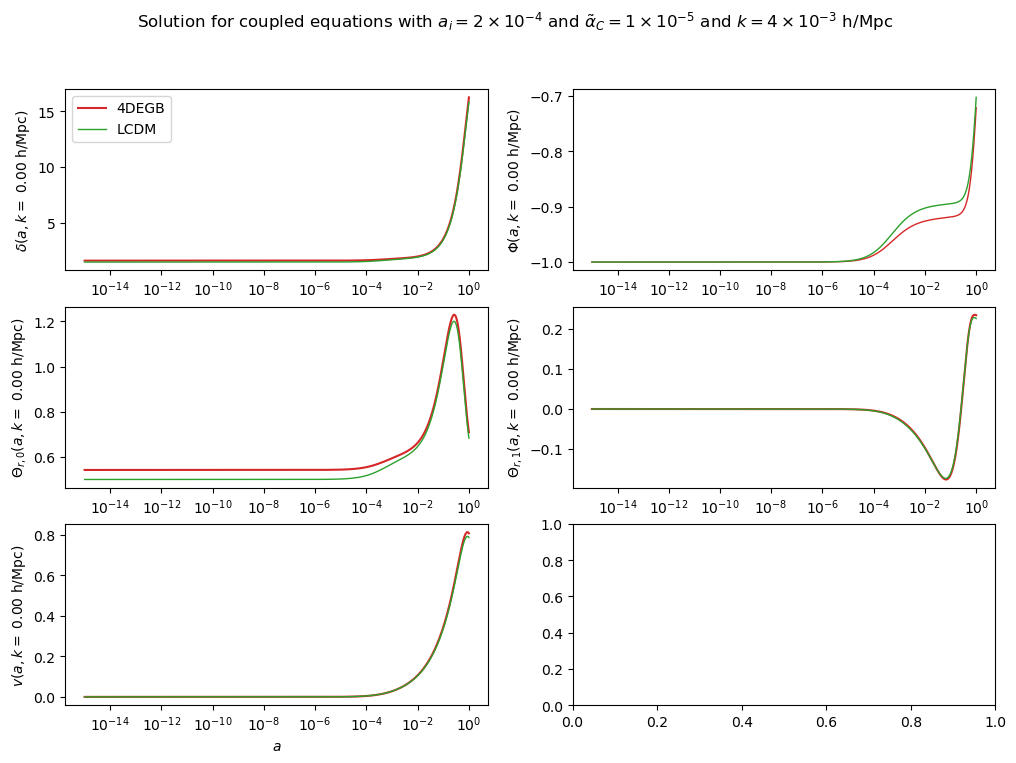

In [15]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(12,8))
fig.suptitle(r'Solution for coupled equations with $a_i = 2 \times 10^{-4}$ and $\tilde{\alpha}_C = 1 \times 10^{-5}$ and $k = 4 \times 10^{-3}$ h/Mpc')


ax1.plot(soln1.t,soln1.y[0], 'tab:red', label = "4DEGB")
ax1.set_ylabel(r"$\delta(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax1.set_xlabel(r"$a$")

ax2.plot(soln1.t,soln1.y[1], 'tab:red',linewidth=1)
ax2.set_ylabel(r"$\Phi(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax2.set_xlabel(r"$a$")

ax3.plot(soln1.t,soln1.y[2], 'tab:red')
ax3.set_ylabel(r"$\Theta_{r,0}(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax3.set_xlabel(r"$a$")

ax4.plot(soln1.t,soln1.y[3], 'tab:red')
ax4.set_ylabel(r"$\Theta_{r,1}(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax4.set_xlabel(r"$a$")

ax5.plot(soln1.t,soln1.y[4], 'tab:red')
ax5.set_ylabel(r"$v(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax5.set_xlabel(r"$a$")



ax1.plot(soln.t,soln.y[0], 'tab:green', label = "LCDM", linewidth=1)
ax2.plot(soln.t,soln.y[1], 'tab:green', linewidth=1)
ax3.plot(soln.t,soln.y[2], 'tab:green', linewidth=1)
ax4.plot(soln.t,soln.y[3], 'tab:green', linewidth=1)
ax5.plot(soln.t,soln.y[4], 'tab:green', linewidth=1)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]

#ax2.plot(soln.t, phi_funct_lowk(soln.t,k,cosmo), color="b",linewidth=1)
#ax2.plot(soln.t, phi_funct_lowk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0]), color="orange",linewidth=1)

#ax2.plot(soln.t, phi_funct_firstorderk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])/phi_funct_firstorderk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])[0], color="g",linewidth=3)

ax1.set_xscale("log")
#ax1.set_ylim(-6,100)
#ax1.set_xlim(1e-10,1)
ax2.set_xscale("log")
#ax2.set_xlim(1e-10,1)
#ax2.set_ylim(0.8,1.2)
ax3.set_xscale("log")
#ax3.set_xlim(1e-7,1)
#ax3.set_ylim(-3.5,3.5)
ax4.set_xscale("log")
#ax4.set_xlim(1e-6,1)
ax5.set_xscale("log")

ax1.legend()
#ax2.plot([5e-4,5e-4],[0.8,1])

#plt.savefig("numerical_soln_coupled1")

print(soln1.y[0][find_nearest(soln.t,1e-10)]/soln1.y[0][0])
print(soln1.y[1][find_nearest(soln.t,1e-10)]/soln1.y[1][0])
print(soln1.y[2][find_nearest(soln.t,1e-10)]/soln1.y[2][0])
print(soln1.y[3][find_nearest(soln.t,1e-10)]/soln1.y[3][0])
print(soln1.y[4][find_nearest(soln.t,1e-10)]/soln1.y[4][0])

      


In [16]:
# Find k_min

# distance between us and CMB
xi_max = xi(1/1101, 1,cosmo)

k_min = 30/xi_max
print(k_min)

9.607446893950415


0.9618022478148534
1.5951448527558694


Text(0, 0.5, '$\\Phi(a, k= $ 0.00 h/Mpc)')

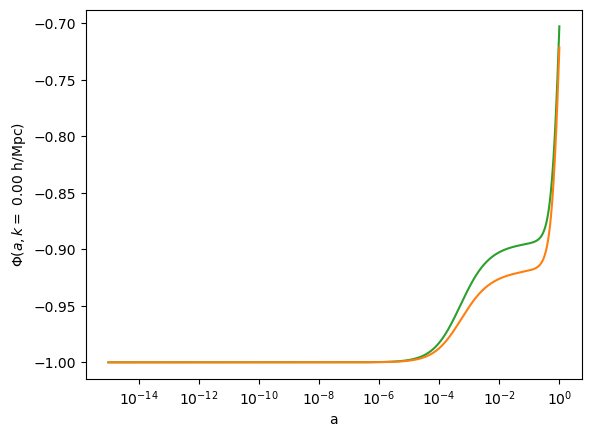

In [17]:
# Checking with small k approximation
alpha_C = 1e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]
a = np.logspace(-7,0,100)
phi_EGB = phi_funct_lowk(a,k_min,[0.264 , 0.0493 , 0 , Omg_rad, 0])[0]*phi_funct_lowk(a,k_min,[0.264 , 0.0493 , 0 , Omg_rad, alpha_C])/\
                                                                                    phi_funct_lowk(a,k_min,[0.264 , 0.0493 , 0 , Omg_rad, alpha_C])[0]
"""
plt.plot(a,phi_EGB)
plt.plot(soln.t,soln.y[1], 'tab:green')
plt.plot(soln1.t,soln1.y[1]/soln1.y[1][find_nearest(soln1.t,1e-7)], 'tab:orange')
plt.plot(a,phi_funct_lowk(a,k_min,[0.264 , 0.0493 , 0 , Omg_rad, 0]))
"""
plt.plot(soln.t,soln.y[1], 'tab:green')
plt.plot(soln1.t,soln1.y[1], 'tab:orange')

a_matterdom = ((cosmo[-1]+cosmo[-2])/(cosmo[0]+cosmo[1]))
phi_EGB_CMB = phi_EGB[find_nearest(a,1/1101)]
phi_GR_CMB = phi_funct_lowk(a,k_min,[0.264 , 0.0493 , 0 , Omg_rad, 0])[find_nearest(a,1/1101)]
phi_EGB_matterdom = phi_EGB[find_nearest(a,a_matterdom)]
phi_GR_matterdom = phi_funct_lowk(a,k_min,[0.264 , 0.0493 , 0 , Omg_rad, 0])[find_nearest(a,a_matterdom)]
print(phi_EGB_CMB/phi_GR_CMB)
print((phi_EGB_CMB - phi_EGB_matterdom)/(phi_GR_CMB - phi_GR_matterdom))
plt.xscale("log")
plt.xlabel("a")
plt.ylabel(r"$\Phi(a, k= $ %.2f h/Mpc)" % float(k/3e3))



0.8795505421549354
0.6494871542916235


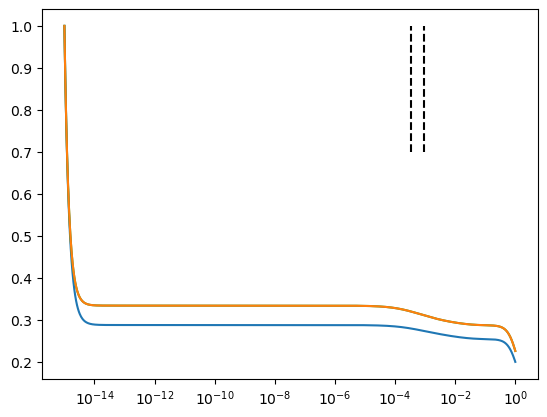

In [18]:
alpha_C = 1e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct = lambda x,y: solution_coupled(x,y, cosmo, k_min)
soln = solve_ivp(funct,
                 (a_0,1), 
                 np.array([3/2,1,1/2,-k_min*a_0/(6*Easquared(a_0, cosmo)), a_0/(2*Easquared(a_0, cosmo))]),
                 t_eval=np.logspace(np.log10(a_0), 0, 1000), 
                 method ='LSODA', 
                 rtol =1e-4)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]

funct1 = lambda x,y: solution_coupled(x,y, cosmo, k_min)

soln1 = solve_ivp(funct1,
                  (a_1,1),
                  np.array([1.377804979*3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,1,1.377804979*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,\
                  -k_min*a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_1, cosmo)), \
                  a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_1, cosmo))]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='LSODA', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)

#print(soln1.y[0][find_nearest(soln.t,1e-10)]/soln1.y[0][0])
#print(soln1.y[1][find_nearest(soln.t,1e-10)]/soln1.y[1][0])
#print(soln1.y[2][find_nearest(soln.t,1e-10)]/soln1.y[2][0])

phi_EGB = soln1.y[1]

phi_GR = soln.y[1]

plt.plot(soln.t,phi_EGB)
plt.plot(soln.t,soln.y[1], 'tab:green')
plt.plot(soln.t,phi_GR)
a_matterdom = ((cosmo[-1]+cosmo[-2])/(cosmo[0]+cosmo[1]))
plt.plot(np.ones(2)/1101, [0.7,1], "k--")
plt.plot(np.ones(2)*a_matterdom, [0.7,1], "k--")

phi_EGB_CMB = phi_EGB[find_nearest(soln.t,1/1101)]
phi_GR_CMB = phi_GR[find_nearest(soln.t,1/1101)]
phi_EGB_matterdom = phi_EGB[find_nearest(soln.t,a_matterdom)]
phi_GR_matterdom = phi_GR[find_nearest(soln.t,a_matterdom)]

#print(phi_EGB_matterdom)
#print(phi_GR_matterdom)
#print(phi_EGB_CMB)
#print(phi_GR_CMB)
print(phi_EGB_CMB/phi_GR_CMB)

# WE NEED TO DISCUSS -- I'm not sure a_matterdom is correct, and I'm not sure this measure here is correct
print((phi_EGB_CMB - phi_EGB_matterdom)/(phi_GR_CMB - phi_GR_matterdom))
plt.xscale("log")